In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load the data
df = pd.read_csv('synthetic_health_data_15000.csv')

# Convert sleep to total minutes
df['total_sleep_minutes'] = df['sleep_hours'] * 60 + df['sleep_minutes']
df.drop(['sleep_hours', 'sleep_minutes'], axis=1, inplace=True)

# Define features and labels
features = ['step_count', 'calories', 'total_sleep_minutes', 'bmi', 'heart_rate_bpm', 'spo2', 'stress_level']
labels = ['Obesity', 'Hypertension', 'Type2Diabetes', 'CVD', 'Anxiety', 'Insomnia']

X = df[features]
y = df[labels]


In [9]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM input: (samples, time_steps=1, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build model
from tensorflow.keras.layers import Bidirectional
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_lstm.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(labels), activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2,
                    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.3713 - loss: 0.5290 - val_accuracy: 0.6958 - val_loss: 0.3604
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4446 - loss: 0.3471 - val_accuracy: 0.5783 - val_loss: 0.2419
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5711 - loss: 0.2334 - val_accuracy: 0.5917 - val_loss: 0.1791
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5760 - loss: 0.2012 - val_accuracy: 0.6292 - val_loss: 0.1713
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5864 - loss: 0.1866 - val_accuracy: 0.6096 - val_loss: 0.1597
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5943 - loss: 0.1818 - val_accuracy: 0.6150 - val_loss: 0.1556
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6057 - loss: 0.1777 - val_accuracy: 0.5808 - val_loss: 0.1516
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6063 - loss: 0.1687 - val_accuracy: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
               precision    recall  f1-score   support

      Obesity       0.84      0.74      0.79       790
 Hypertension       0.98      0.96      0.97       740
Type2Diabetes       0.71      0.59      0.64       173
          CVD       0.54      0.18      0.27        79
      Anxiety       0.96      0.81      0.88       269
     Insomnia       0.90      0.89      0.90       708

    micro avg       0.90      0.82      0.86      2759
    macro avg       0.82      0.69      0.74      2759
 weighted avg       0.89      0.82      0.85      2759
  samples avg       0.50      0.48      0.48      2759

Accuracy: 0.78
ROC AUC (macro): 0.9782


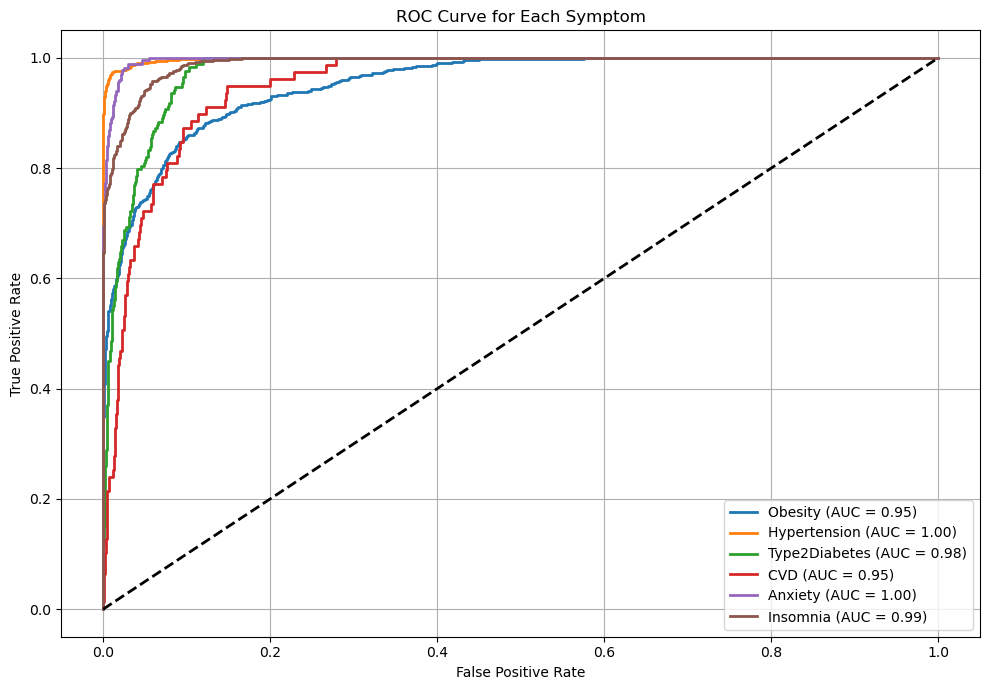

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred_bin = (y_pred_prob > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred_bin, target_names=labels,zero_division=0))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_bin))

# ROC AUC score (filtered for valid labels)
valid = [i for i in range(y_test.shape[1]) if len(np.unique(y_test.iloc[:, i])) == 2]
if valid:
    auc = roc_auc_score(y_test.iloc[:, valid], y_pred_prob[:, valid], average='macro')
    print("ROC AUC (macro):", round(auc, 4))
else:
    print("Not enough label diversity to calculate ROC AUC.")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each label
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Symptom')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
print(df.columns.tolist())

['step_count', 'calories', 'bmi', 'heart_rate_bpm', 'spo2', 'stress_level', 'Obesity', 'Hypertension', 'Type2Diabetes', 'CVD', 'Anxiety', 'Insomnia', 'total_sleep_minutes']


In [24]:
def predict_manual(step_count, calories, sleep_hours, sleep_minutes, bmi, heart_rate_bpm, spo2, stress_level):
    total_sleep_minutes = sleep_hours * 60 + sleep_minutes
    input_array = np.array([[step_count, calories, total_sleep_minutes, bmi, heart_rate_bpm, spo2, stress_level]])
    input_scaled = scaler.transform(input_array)
    input_lstm = input_scaled.reshape((1, 1, input_scaled.shape[1]))
    prob = model.predict(input_lstm)
    pred = (prob > 0.5).astype(int)
    
    for i, label in enumerate(labels):
        result = "Positive" if pred[0][i] else "Negative"
        print(f"{label}: {result}")


In [25]:
predict_manual(1000, 200, 3, 0, 34.5, 108, 86, 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Obesity: Positive
Hypertension: Positive
Type2Diabetes: Positive
CVD: Negative
Anxiety: Negative
Insomnia: Positive


In [27]:
model.save("health_model.keras")
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
